# Data Loader
This notebook focuses on developing a data loader and augmentation process for a binary classification task using the SOCOFing dataset. The goal is to classify fingerprints as either 'Real' or 'Altered'.

The process involves:
* Load and checking the data structure
* Cleaning the data by checking for unusable images
* Creating a subset of images for training and testing using image_dataset_from_directory
* Organizing the data into class-specific subdirectories with a maximum of 100 per class
* Implementing a data loader and visualizing the loaded images
* Applying basic data augmentation techniques to the training set
* Create a module that holds the data loader to reuse


# Load the data

In [ ]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import shutil


# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

In [ ]:
# Define base paths for the dataset
base_path = os.path.join(extracted_path, 'SOCOFing')
altered_base_path = os.path.join(base_path, 'Altered')
real_images_path = os.path.join(base_path, 'Real')

# Print dataset structure and image counts
print("Dataset Structure and Image Counts:")
print("-" * 30)

# Count real images
if os.path.isdir(real_images_path):
    real_image_count = len([name for name in os.listdir(real_images_path) if name.lower().endswith('.bmp')])
    print(f"Real images: {real_image_count}")
else:
    print(f"Directory not found: {real_images_path}")

# Count altered images by difficulty level and in total
altered_total_count = 0
print("Altered images:")
for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    level_path = os.path.join(altered_base_path, difficulty_level)
    if os.path.isdir(level_path):
        level_image_count = len([name for name in os.listdir(level_path) if name.lower().endswith('.bmp')])
        print(f"  {difficulty_level}: {level_image_count}")
        altered_total_count += level_image_count
    else:
        print(f"  Directory not found: {level_path}")

print(f"Total Altered images: {altered_total_count}")

Dataset Structure and Image Counts:
------------------------------
Real images: 6000
Altered images:
  Altered-Easy: 17931
  Altered-Medium: 17067
  Altered-Hard: 14272
Total Altered images: 49270


## Data cleaning


In [ ]:
# Check for and remove any corrupted images in the dataset.

from PIL import Image

# list to store corrupted image paths
corrupted_images = []

def check_corrupted(directory_path):
    if os.path.isdir(directory_path):
        for filename in os.listdir(directory_path):
            if filename.lower().endswith('.bmp'):
                img_path = os.path.join(directory_path, filename)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception:
                    corrupted_images.append(img_path)
    else:
        print(f"Directory not found: {directory_path}")

# Check for corrupted images in Real and Altered directories
real_images_path = os.path.join(base_path, 'Real')
check_corrupted(real_images_path)

altered_base_path = os.path.join(base_path, 'Altered')
for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    level_path = os.path.join(altered_base_path, difficulty_level)
    check_corrupted(level_path)
if corrupted_images:
    print("Corrupted images found:")
    for img_path in corrupted_images:
        print(img_path)
else:
    print("No corrupted images found.")

No corrupted images found.


## Creating a subset


In [ ]:
## making a smaller subset with  100 images per class for both training and testing (80/20 split).
max_images_per_class = 100

# Get all image file paths for each class
real_image_files = [os.path.join(real_images_path, name) for name in os.listdir(real_images_path) if name.lower().endswith('.bmp')]
altered_image_files = []
for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
    level_path = os.path.join(altered_base_path, difficulty_level)
    if os.path.isdir(level_path):
        altered_image_files.extend([os.path.join(level_path, name) for name in os.listdir(level_path) if name.lower().endswith('.bmp')])

# Shuffle the file lists
np.random.seed(42)
np.random.shuffle(real_image_files)
np.random.shuffle(altered_image_files)

# Take a subset of the images
real_subset_files = real_image_files[:max_images_per_class]
altered_subset_files = altered_image_files[:max_images_per_class]

# Split the subset files into training and testing sets
validation_split_ratio = 0.2
num_test_per_class = int(max_images_per_class * validation_split_ratio)
num_train_per_class = max_images_per_class - num_test_per_class
real_train_files = real_subset_files[:num_train_per_class]
real_test_files = real_subset_files[num_train_per_class:]
altered_train_files = altered_subset_files[:num_train_per_class]
altered_test_files = altered_subset_files[num_train_per_class:]

print(f"Real train images: {len(real_train_files)}")
print(f"Real test images: {len(real_test_files)}")
print(f"Altered train images: {len(altered_train_files)}")
print(f"Altered test images: {len(altered_test_files)}")

Real train images: 80
Real test images: 20
Altered train images: 80
Altered test images: 20


In [ ]:
# Define the base path for the organized dataset
organized_dataset_path = 'organized_fingerprint_dataset'

# Define paths for train and test directories for each class
train_real_dir = os.path.join(organized_dataset_path, 'train', 'Real')
train_altered_dir = os.path.join(organized_dataset_path, 'train', 'Altered')
test_real_dir = os.path.join(organized_dataset_path, 'test', 'Real')
test_altered_dir = os.path.join(organized_dataset_path, 'test', 'Altered')

# Create the directories if they don't exist and clear previous contents
if os.path.exists(organized_dataset_path):
    shutil.rmtree(organized_dataset_path)
os.makedirs(train_real_dir, exist_ok=True)
os.makedirs(train_altered_dir, exist_ok=True)
os.makedirs(test_real_dir, exist_ok=True)
os.makedirs(test_altered_dir, exist_ok=True)


# Function to copy files to a destination directory, handling duplicate basenames
def copy_files(file_list, destination_dir):
    for file_path in file_list:
        try:
            base_name, ext = os.path.splitext(os.path.basename(file_path))
            destination_file_path = os.path.join(destination_dir, os.path.basename(file_path))
            # Check if a duplicate exists
            counter = 1
            while os.path.exists(destination_file_path):
                destination_file_name = f"{base_name}_{counter}{ext}"
                destination_file_path = os.path.join(destination_dir, destination_file_name)
                counter += 1
            shutil.copy(file_path, destination_file_path)
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
        except Exception as e:
            print(f"Error copying file {file_path}: {e}")

copy_files(real_train_files, train_real_dir)
copy_files(real_test_files, test_real_dir)
copy_files(altered_train_files, train_altered_dir)
copy_files(altered_test_files, test_altered_dir)

print(f"Dataset organized in '{organized_dataset_path}'")

# Remove the original extracted directory to keep only the subset
original_extracted_path = '/content/SOCOFing_extracted'
if os.path.exists(original_extracted_path):
    try:
        shutil.rmtree(original_extracted_path)
        print(f"Removed original extracted dataset at '{original_extracted_path}'")
    except Exception as e:
        print(f"Error removing original extracted dataset: {e}")
else:
    print(f"Original extracted dataset not found at '{original_extracted_path}', no need to remove.")

Dataset organized in 'organized_fingerprint_dataset'
Original extracted dataset not found at '/content/SOCOFing_extracted', no need to remove.


## Data Loader

In [ ]:
import tensorflow as tf

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Define dataset paths based on the organized structure
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Create training dataset from the 'train' directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Create validation dataset from the test directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,  # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']


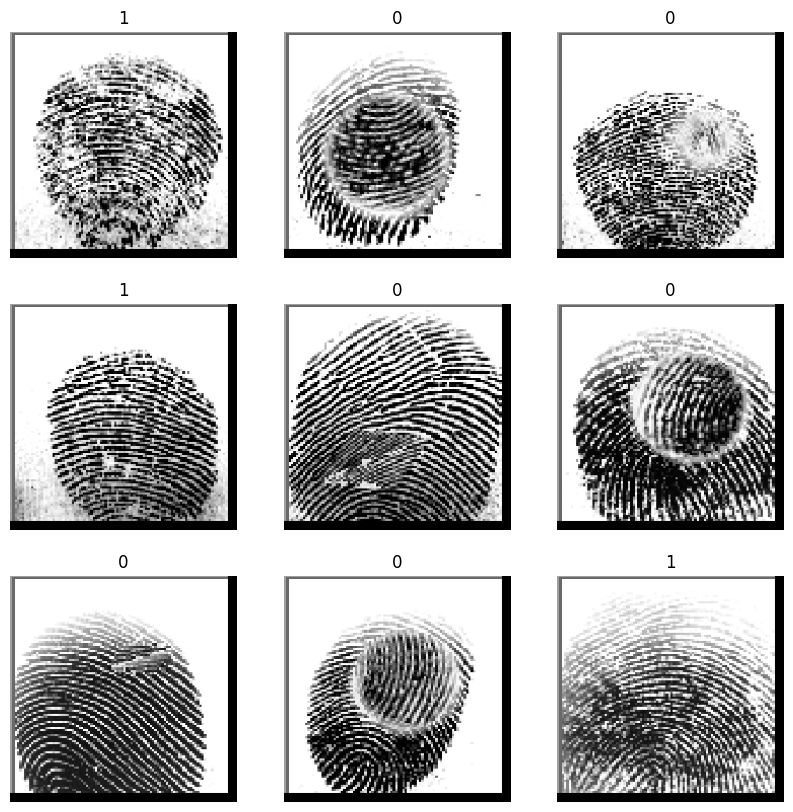

In [ ]:
# visualize one batch of images and labels from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

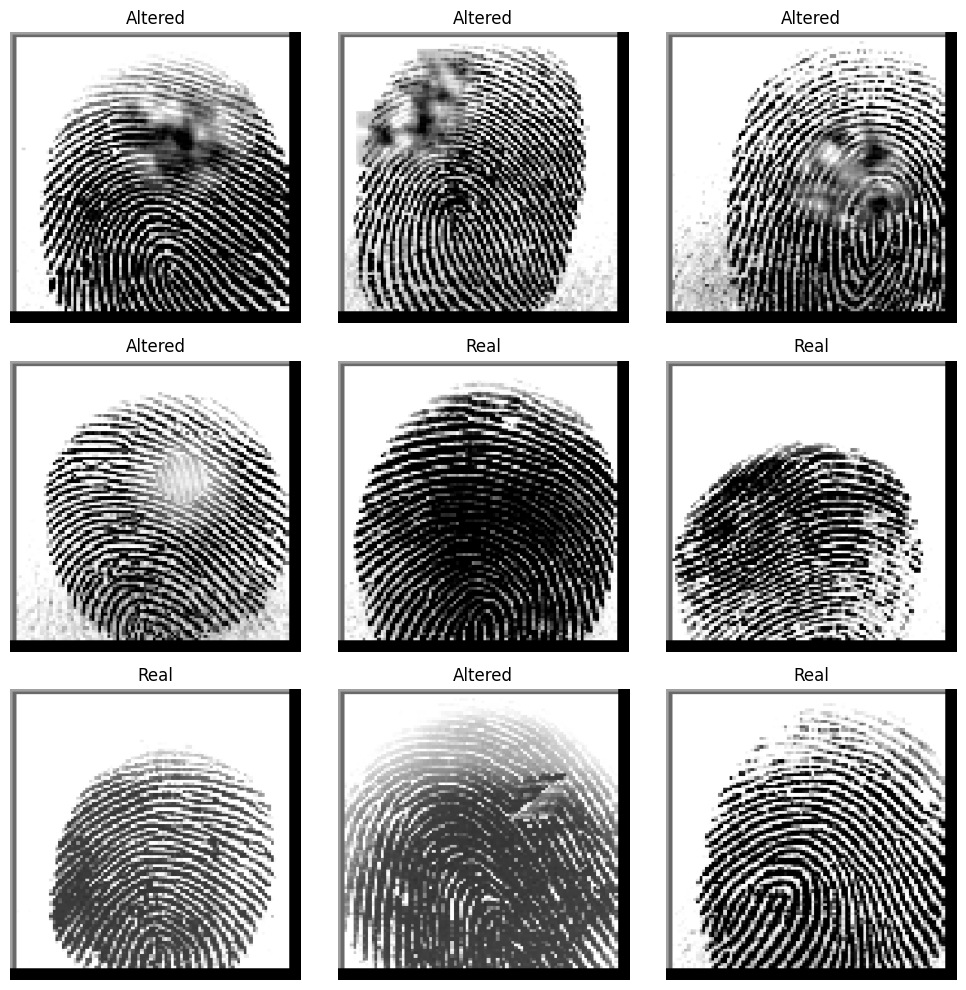

In [ ]:
# more visualization not using binary
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## Data Augmentation


In [ ]:
# Data Augmentation Layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

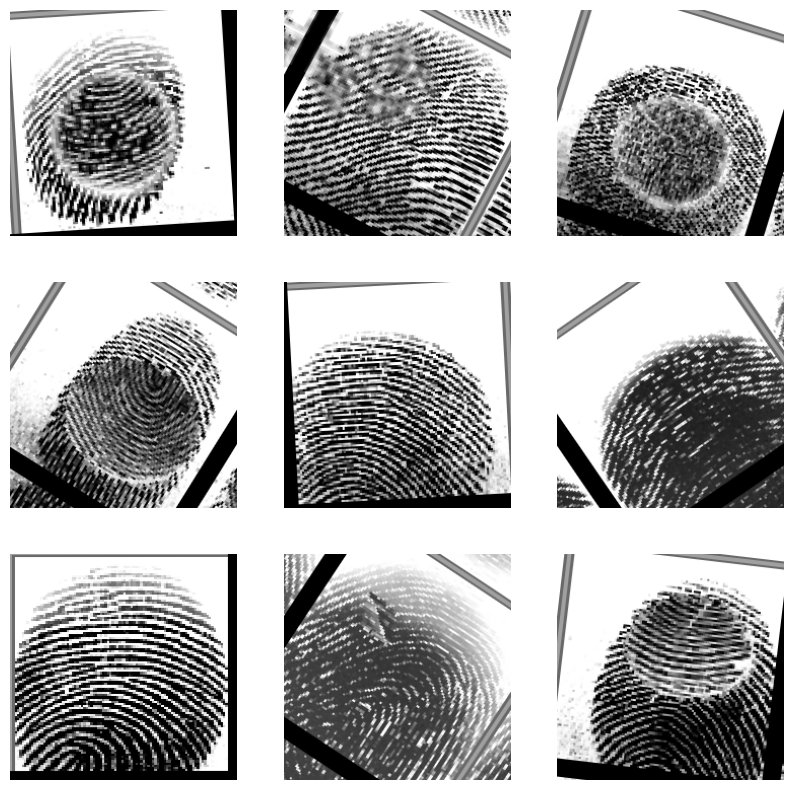

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

In [ ]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 177s 10s/step - acc: 0.6511 - loss: 0.6538 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 178s 11s/step - acc: 0.7189 - loss: 0.6266 - val_acc: 0.5000 - val_loss: 0.6938
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 209s 12s/step - acc: 0.7606 - loss: 0.5435 - val_acc: 0.5000 - val_loss: 0.6952
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 183s 10s/step - acc: 0.7978 - loss: 0.4332 - val_acc: 0.5000 - val_loss: 0.6984
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 156s 10s/step - acc: 0.7738 - loss: 0.3966 - val_acc: 0.5000 - val_loss: 0.7065
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 155s 10s/step - acc: 0.8522 - loss: 0.3542 - val_acc: 0.5000 - val_loss: 0.7173
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 208s 10s/step - acc: 0.8417 - loss: 0.3453 - val_acc: 0.5000 - val_loss: 0.7359
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 163s 10s/step - acc: 0.8464 - loss: 0.3160 - val_acc: 0.5000 - val_loss: 0.7591


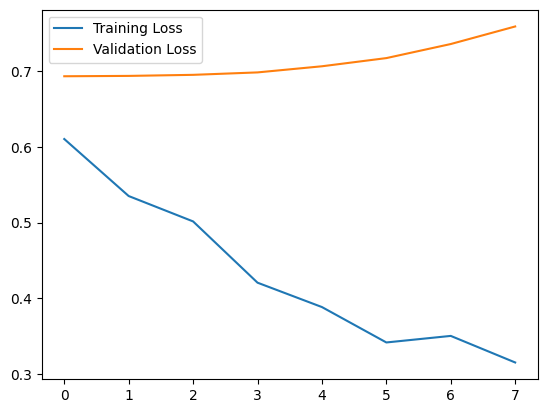

In [ ]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

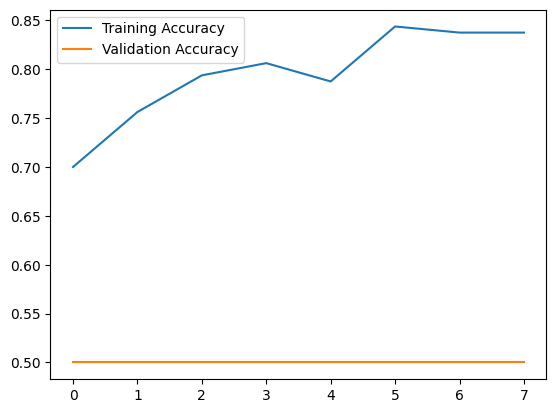

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

# Module holder

In [ ]:
%%writefile data_utils.py

import os
import numpy as np
import tensorflow as tf
from keras import layers
import zipfile
import shutil
from PIL import Image

def check_corrupted(directory_path):
    """Checks for and removes any corrupted images in the dataset."""
    corrupted_images = []
    if os.path.isdir(directory_path):
        for filename in os.listdir(directory_path):
            if filename.lower().endswith('.bmp'):
                img_path = os.path.join(directory_path, filename)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception:
                    corrupted_images.append(img_path)
    return corrupted_images

def organize_dataset(extracted_path='extracted_socofing', organized_dataset_path='organized_fingerprint_dataset', max_images_per_class=100, validation_split_ratio=0.2):
    """Organizes the dataset into train and test directories with a subset of images."""
    base_path = os.path.join(extracted_path, 'SOCOFing')
    altered_base_path = os.path.join(base_path, 'Altered')
    real_images_path = os.path.join(base_path, 'Real')

    real_image_files = [os.path.join(real_images_path, name) for name in os.listdir(real_images_path) if name.lower().endswith('.bmp')]
    altered_image_files = []
    for difficulty_level in ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']:
        level_path = os.path.join(altered_base_path, difficulty_level)
        if os.path.isdir(level_path):
            altered_image_files.extend([os.path.join(level_path, name) for name in os.listdir(level_path) if name.lower().endswith('.bmp')])

    np.random.seed(42)
    np.random.shuffle(real_image_files)
    np.random.shuffle(altered_image_files)

    real_subset_files = real_image_files[:max_images_per_class]
    altered_subset_files = altered_image_files[:max_images_per_class]

    num_test_per_class = int(max_images_per_class * validation_split_ratio)
    num_train_per_class = max_images_per_class - num_test_per_class

    real_train_files = real_subset_files[:num_train_per_class]
    real_test_files = real_subset_files[num_train_per_class:]
    altered_train_files = altered_subset_files[:num_train_per_class]
    altered_test_files = altered_subset_files[num_train_per_class:]

    train_real_dir = os.path.join(organized_dataset_path, 'train', 'Real')
    train_altered_dir = os.path.join(organized_dataset_path, 'train', 'Altered')
    test_real_dir = os.path.join(organized_dataset_path, 'test', 'Real')
    test_altered_dir = os.path.join(organized_dataset_path, 'test', 'Altered')

    if os.path.exists(organized_dataset_path):
        shutil.rmtree(organized_dataset_path)
    os.makedirs(train_real_dir, exist_ok=True)
    os.makedirs(train_altered_dir, exist_ok=True)
    os.makedirs(test_real_dir, exist_ok=True)
    os.makedirs(test_altered_dir, exist_ok=True)

    def copy_files(file_list, destination_dir):
        for file_path in file_list:
            try:
                base_name, ext = os.path.splitext(os.path.basename(file_path))
                destination_file_path = os.path.join(destination_dir, os.path.basename(file_path))
                counter = 1
                while os.path.exists(destination_file_path):
                    destination_file_name = f"{base_name}_{counter}{ext}"
                    destination_file_path = os.path.join(destination_dir, destination_file_name)
                    counter += 1
                shutil.copy(file_path, destination_file_path)
            except FileNotFoundError:
                print(f"Warning: File not found at {file_path}. Skipping.")
            except Exception as e:
                print(f"Error copying file {file_path}: {e}")

    copy_files(real_train_files, train_real_dir)
    copy_files(real_test_files, test_real_dir)
    copy_files(altered_train_files, train_altered_dir)
    copy_files(altered_test_files, test_altered_dir)

    print(f"Dataset organized in '{organized_dataset_path}'")


def create_datasets(organized_dataset_path='organized_fingerprint_dataset', image_size=(224, 224), batch_size=10):
    """Creates training and validation datasets using image_dataset_from_directory."""
    train_dir = os.path.join(organized_dataset_path, 'train')
    test_dir = os.path.join(organized_dataset_path, 'test')

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='binary',
        image_size=image_size,
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        seed=42
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='binary',
        image_size=image_size,
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=False,
        seed=42
    )

    class_names = train_ds.class_names
    print(f"Class names: {class_names}")

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names

def apply_data_augmentation(dataset):
    """Applies data augmentation to the dataset."""
    data_augmentation_layers = [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]

    def data_augmentation(images):
        for layer in data_augmentation_layers:
            images = layer(images)
        return images

    augmented_ds = dataset.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    augmented_ds = augmented_ds.prefetch(tf.data.AUTOTUNE)
    return augmented_ds